In [1]:
%matplotlib inline

import numpy as np
import struct
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

plt.style.use('ggplot')

Задаем параметры:
* window_size -- размер окна для вычисления оконной дисперсии
* window_size_2 -- размер окна для сравнения средних
* min_dist -- минимальное расстояние между двумя соседними точками

In [2]:
window_size = 32
window_size_2 = 64

min_dist = 4 * window_size_2

Функция, которая загружает файл.

Файл хранится в бинарном формате следующей структуры:
* Байты 0-3: содержат размер временного ряда, тип _unsigned int_.
* Байты (4 + 8i)-(4 + 8(i+1)): содержат i-ый член временного ряда, тип _double_.

In [3]:
def load_bin(fname):
    raw = open(fname,'rb').read()

    length, = struct.unpack('I', raw[:4])
    data = np.array(struct.unpack('d' * length, raw[4:]))

    return data

Считываем временной ряд и печатаем первые 10 его элементов, чтобы убедиться, что данные загружены корректно.

In [4]:
miog = load_bin('data/miog.bin')
print(miog[:10])

[0.00067062 0.00067437 0.00067562 0.00067812 0.00067937 0.00067625
 0.00066625 0.00065125 0.00064062 0.00063625]


Вычисляем оконную дисперсию. Сначала необходимо посчитать оконное среднее, затем вторым проходом вычисляется оконная дисперсия.

Заметим, что для значение оконной дисперсии будет храниться по индексу левой точки окна.

In [5]:
rolling_mean = np.zeros(miog.shape[0] - (window_size - 1))
rolling_var  = np.zeros(miog.shape[0] - (window_size - 1))

for i in tqdm(range(miog.shape[0] - (window_size - 1))):
    # считаем среднее
    loc = 0
    for k in range(window_size):
        loc += miog[i+k]
    rolling_mean[i] = loc / window_size
    
    # считаем дисперсию
    loc = 0
    for k in range(window_size):
        loc += np.power(miog[i+k] - rolling_mean[i], 2)
    rolling_var[i] = loc / (window_size - 1)

print(rolling_mean[:10])
print(rolling_var [:10])


[0.00066012 0.00065916 0.00065809 0.00065687 0.00065559 0.00065449
 0.00065389 0.00065387 0.00065441 0.00065564]
[6.28363135e-10 6.36910804e-10 6.40094466e-10 6.43170626e-10
 6.39792022e-10 6.24356023e-10 6.08889709e-10 6.08403396e-10
 6.15018825e-10 6.28439877e-10]


Теперь вычисляем квантиль q_alpha заданного уровня.

Выборочной оценкой квантили является k-ая порядковая статистика, где
    
    k = round(alpha * N)

Здесь N -- длина временного ряда.

In [6]:
alpha = 0.70

# копируем оконную дисперсию и сортируем, чтобы получить вариационный ряд.
var_cdf = rolling_var.copy()
var_cdf.sort()

print(var_cdf.shape[0], int(alpha * var_cdf.shape[0]))

q_alpha = var_cdf[int(alpha * var_cdf.shape[0])]
q_alpha

417969 292578


1.0614411678770505e-09

Теперь применяем метод сравнения средних для окон размера window_size_2.

Если средние в них отличаются более чем на q_alpha, то в точки правого окна помечаем как точки движения.

In [7]:
moving = [0]
moving_x = [0]

for i in tqdm(range(1, int(len(rolling_var) / window_size_2))):
    w1 = rolling_var[window_size_2 * (i-1):window_size_2 * (i)]
    w2 = rolling_var[window_size_2 * i:window_size_2 * (i+1)]
    
    m1 = w1.mean()
    m2 = w2.mean()
    
    if(i < 10):
        print(m1,m2)
    if np.abs(m1 - m2) > q_alpha:
        moving += [1]
    else:
        moving += [0]
    moving_x += [window_size_2 * i]

moving = np.array(moving)

5.921809844191567e-10 5.638118410992226e-10
5.638118410992226e-10 5.345682934567045e-10
5.345682934567045e-10 4.955527941805357e-10
4.955527941805357e-10 5.679419825114425e-10
5.679419825114425e-10 5.632460003098516e-10
5.632460003098516e-10 5.124788543065514e-10
5.124788543065514e-10 6.246888305799815e-10
6.246888305799815e-10 5.095962381456505e-10
5.095962381456505e-10 5.903357955515857e-10



Помечаем все точки ряда, которые стоят на границе между промежутками нулей и единиц.

In [8]:
support_points = []

for i in tqdm(range(1,len(moving))):
    if (moving[i] == 1 and moving[i-1] == 0
        and(len(support_points) == 0 or moving_x[i] - support_points[-1] > min_dist)):
        support_points.append(moving_x[i])

Строим график

8907.58309526933


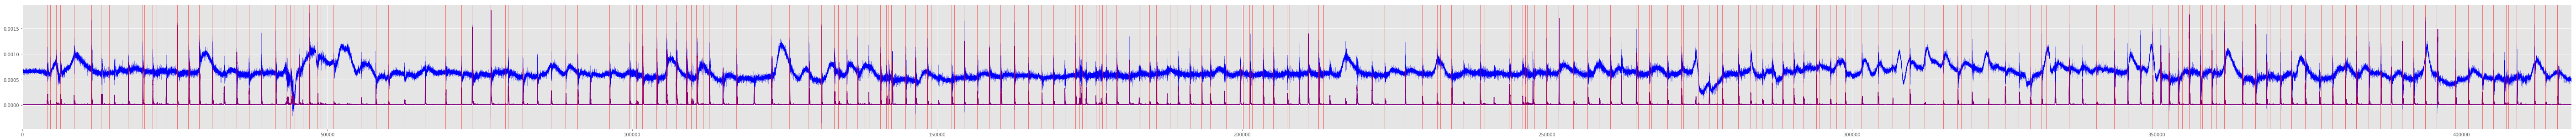

In [9]:
_,ax = plt.subplots(1,1,figsize=(100,5))

scaler = miog.max() / rolling_var.max()
print(scaler)

ax.plot(miog,color='blue',lw=0.2)

rolling_x = list(range(window_size-1, miog.shape[0]))
ax.plot(rolling_x, rolling_var * scaler,color='purple')

for pt in support_points:
    ax.axvline(window_size + pt,color='red',lw=0.5)

ax.set_xbound(0,miog.shape[0])
plt.show()